In [27]:
import os
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from textblob import TextBlob
import pandas as pd
import numpy as np
from collections import Counter
from time import time
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import requests
from sklearn.model_selection import learning_curve
from sklearn.ensemble import VotingClassifier
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Get data from specified path:

In [0]:
RENTAL_PATH = '/content/drive/My Drive/Rental data'

def fetch_data(file_name):
    path_to_file = os.path.join(RENTAL_PATH, file_name)
    return pd.read_json(path_to_file)

rental = fetch_data('train.json')
rental.reset_index(inplace=True)
rental.drop('index', axis=1, inplace=True)
rental_test = fetch_data('test.json')

Add count features:

In [0]:
rental["photos_number"] = rental["photos"].apply(len)
rental["descripton_number_of_words"] = rental["description"].apply(lambda description: len(TextBlob(description).words))

rental_test["photos_number"] = rental_test["photos"].apply(len)
rental_test["descripton_number_of_words"] = rental_test["description"].apply(lambda description: len(TextBlob(description).words))


Engineer manager features:

In [0]:
index = list(range(rental.shape[0]))
random.shuffle(index)
a = [np.nan] * len(rental)
b = [np.nan] * len(rental)
c = [np.nan] * len(rental)

for i in range(5):
    building_level = {}
    for j in rental['manager_id'].values:
        building_level[j] = [0, 0, 0]
    test_index = index[int((i * rental.shape[0]) / 5):int(((i + 1) * rental.shape[0]) / 5)]
    train_index = list(set(index).difference(test_index))
    for j in train_index:
        temp=rental.iloc[j]
        if temp['interest_level'] == 'low':
            building_level[temp['manager_id']][0] += 1
        if temp['interest_level'] == 'medium':
            building_level[temp['manager_id']][1] += 1
        if temp['interest_level'] == 'high':
            building_level[temp['manager_id']][2] += 1
    for j in test_index:
        temp=rental.iloc[j]
        if sum(building_level[temp['manager_id']]) != 0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
rental['manager_low_level'] = a
rental['manager_medium_level'] = b
rental['manager_high_level'] = c

a = []
b = []
c = []
building_level = {}
for j in rental['manager_id'].values:
    building_level[j] = [0, 0, 0]
for j in range(rental.shape[0]):
    temp=rental.iloc[j]
    if temp['interest_level'] == 'low':
        building_level[temp['manager_id']][0] += 1
    if temp['interest_level'] == 'medium':
        building_level[temp['manager_id']][1] += 1
    if temp['interest_level'] == 'high':
        building_level[temp['manager_id']][2] += 1

for i in rental_test['manager_id'].values:
    if i not in building_level.keys():
        a.append(np.nan)
        b.append(np.nan)
        c.append(np.nan)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
rental_test['manager_low_level'] = a
rental_test['manager_medium_level'] = b
rental_test['manager_high_level'] = c

manager_columns = ['manager_low_level', 'manager_medium_level', 'manager_high_level']
simple_imputer = SimpleImputer(strategy='median')
rental[manager_columns] = simple_imputer.fit_transform(rental[manager_columns])
rental_test[manager_columns] = simple_imputer.fit_transform(rental_test[manager_columns])

Explore numurical columns:

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


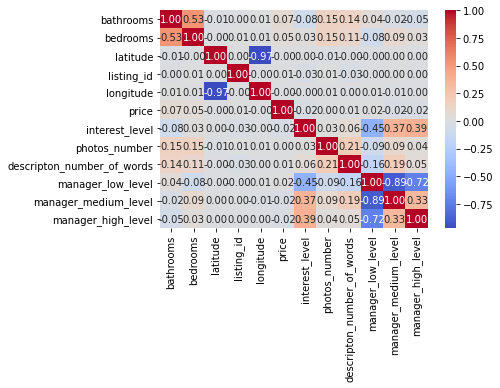

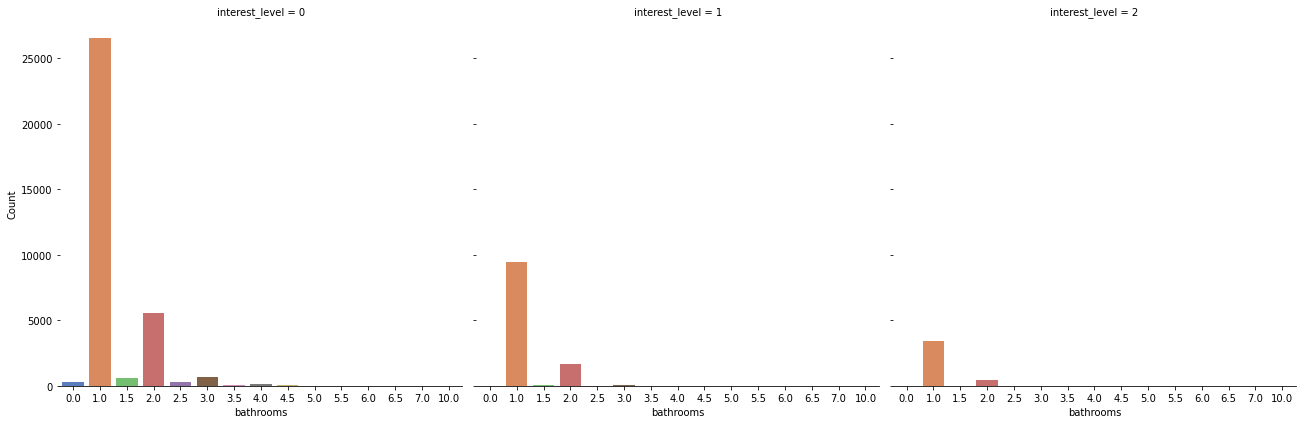

In [5]:
for index, record in enumerate(rental['interest_level']):
    if (record == 'medium'):
        rental['interest_level'].iloc[index] = 1
    if (record == 'high'):
        rental['interest_level'].iloc[index] = 2
    if (record == 'low'):
        rental['interest_level'].iloc[index] = 0

rental['interest_level'] = rental['interest_level'].astype(int)

sns.heatmap(rental.corr(), annot=True, fmt=".2f", cmap="coolwarm")

g = sns.factorplot("bathrooms", col="interest_level",  data=rental,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")


Extract features from 'features' column:

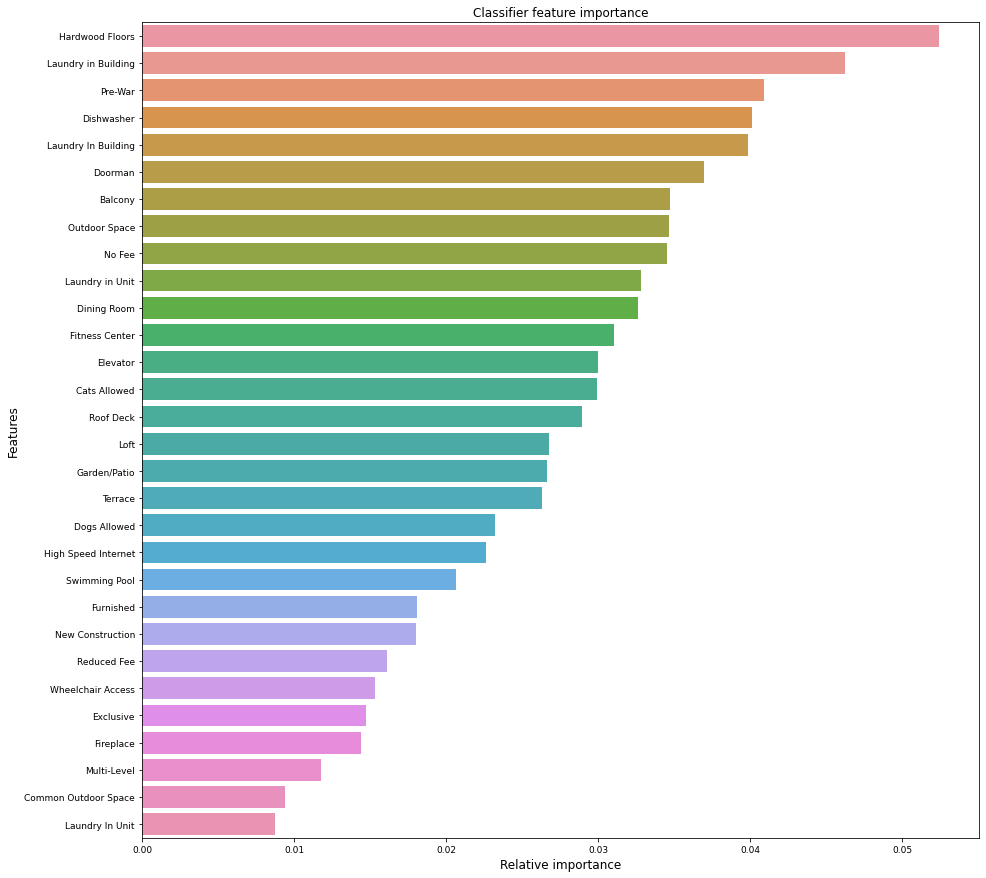

In [6]:
def add_features(rental):
  features = rental['features']
  features_dic = []
  for features_record in features:
      for feature in features_record:
          features_dic.append(feature)

  features_counted = Counter(features_dic)
  features_descending = features_counted.most_common()

  features_set = []
  for key, value in features_descending:
      features_set.append(key)

  rental_new = pd.DataFrame(0, index=np.arange(len(rental)), columns=features_set)
  len(rental_new)
  rental_new.dropna(inplace=True)

  start = time()
  for index, record in enumerate(features):
      for feature in record:
          rental_new._set_value(index, feature, 1)
  end = time()
  return rental_new

rental_new = add_features(rental)
rental_new_test = add_features(rental_test)

X = rental_new
y = rental['interest_level']

tree_clf = DecisionTreeClassifier()
name = 'Classifier'
classifier = tree_clf
classifier.fit(X, y)

plt.figure(figsize=(15, 15))
indices = np.argsort(classifier.feature_importances_)[::-1][:30]
g = sns.barplot(y=X.columns[indices], x=classifier.feature_importances_[indices], orient='h')
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")

features_top30 = list(X.columns[indices])

rental_new = rental_new[features_top30]
rental_new_test = rental_new_test[features_top30]

rental = pd.concat([rental, rental_new], axis=1)
rental_test = pd.concat([rental_test, rental_new_test], axis=1)

Add feature based on time a listing was published:

In [7]:
def add_days_feature(rental):
  rental['days_elapsed'] = np.nan
  date_now = '2017-01-01 00:00:00'
  date_now_obj = datetime.strptime(date_now, '%Y-%m-%d %H:%M:%S')

  for index, date_created in enumerate(rental['created']):
      if (type(date_created) == str):
        date_created_obj = datetime.strptime(date_created, '%Y-%m-%d %H:%M:%S')
        delta = date_now_obj - date_created_obj
        rental['days_elapsed'].iloc[index] = int(delta.days)
      else:
        rental['days_elapsed'].iloc[index] = 0
  return rental

rental = add_days_feature(rental)
rental_test = add_days_feature(rental_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Drop unnecessary features:

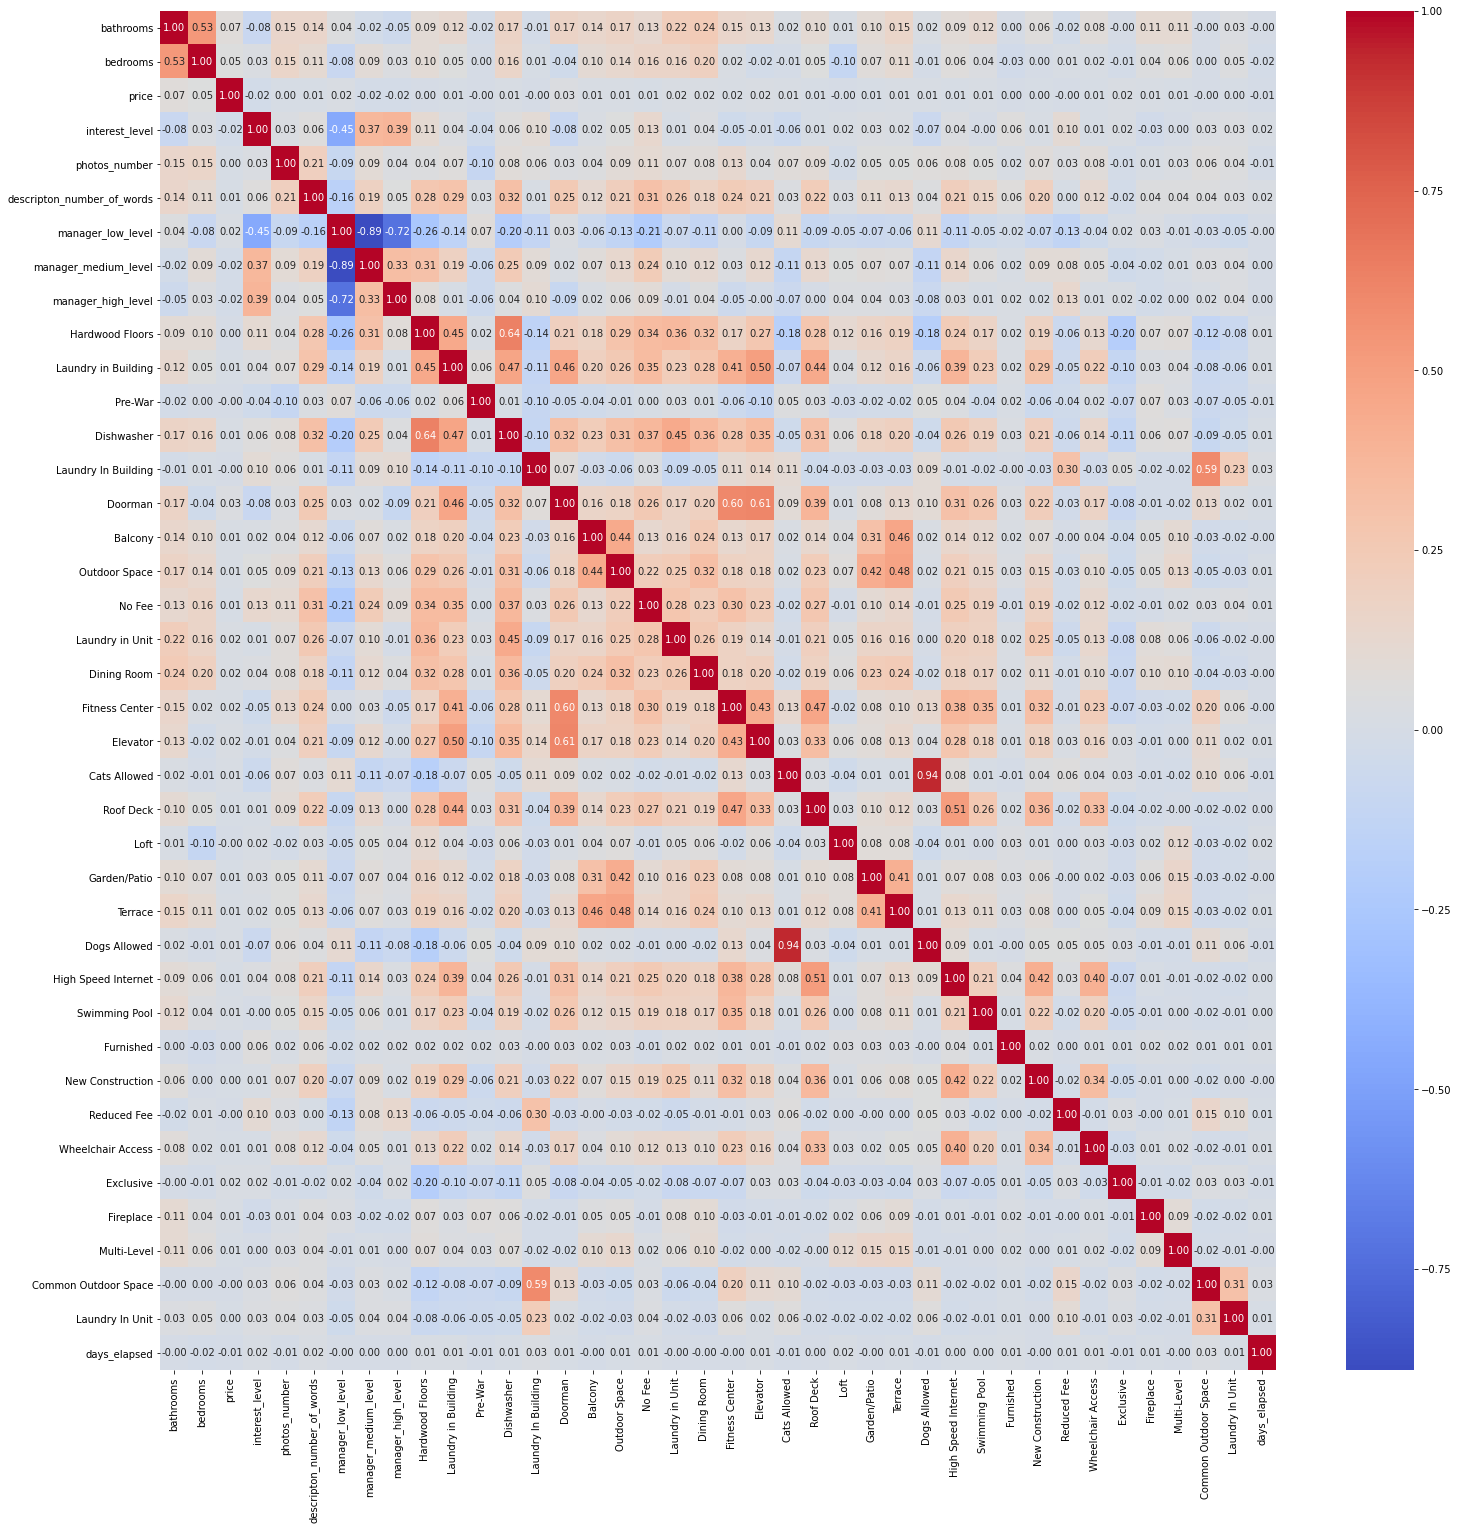

In [8]:
columns_to_drop = ['latitude', 'longitude', 'listing_id',
                   'created', 'display_address',
                   'building_id', 'features', 'street_address',
                   'description', 'photos', 'manager_id']
rental.drop(columns_to_drop, axis=1, inplace=True)
rental_test.drop(columns_to_drop, axis=1, inplace=True)

plt.figure(figsize=(25, 25))
g = sns.heatmap(rental.corr(),
                annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Train different models:

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


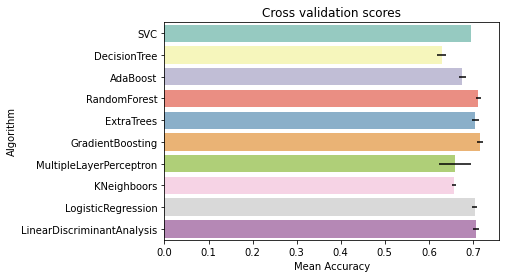

In [19]:
rental_set = list(rental)
indexes_to_delete = [2, 15, 17, 19, 21, 23, 24, 27, 28, 31, 33, 34, 37]
for index in indexes_to_delete:
  rental_set[index] = 0
for i in range(len(indexes_to_delete)):
  rental_set.remove(0)

X_train = rental[rental_set].drop('interest_level', axis=1)
y_train = rental['interest_level']

rental_set_test = list(rental_test)
indexes_to_delete = [1, 14, 16, 18, 20, 22, 23, 26, 27, 30, 32, 33, 36]
for index in indexes_to_delete:
  rental_set_test[index] = 0
for i in range(len(indexes_to_delete)):
  rental_set_test.remove(0)

X_test = rental_test[rental_set_test]

kfold = StratifiedKFold(n_splits=10)

#Test chosen classifiers:
random_state = 3
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring="accuracy", cv=kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

Tune GradientBoostingClassifier:

In [0]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100, 300],
              'learning_rate': [0.1, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100, 150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Tune RandomForrestClassifier:

In [0]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid=rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)

gsRFC.fit(X_train, y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Tune ExtraTrees classifier:

In [0]:
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Plot learning curves:

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


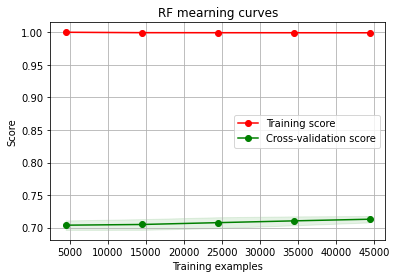

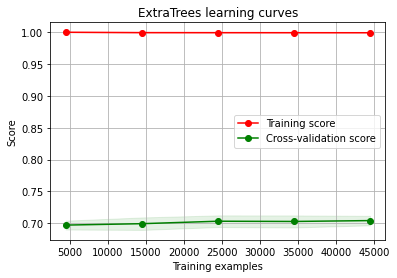

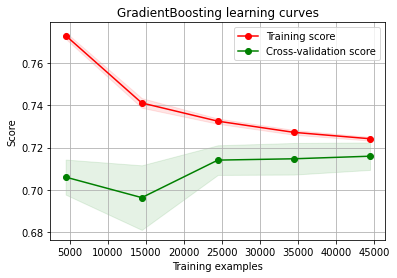

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


g = plot_learning_curve(RFC_best, "RF mearning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(ExtC_best, "ExtraTrees learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(GBC_best, "GradientBoosting learning curves", X_train, y_train, cv=kfold)



Ensemble tuned classifiers to Voting classifier:

In [0]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
                                       ('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)
predictions = votingC.predict_proba(rental_test)

submission = pd.DataFrame(preds)
submission.columns = ["high", "medium", "low"]
submission["listing_id"] = rental_test.listing_id.values
submission.to_csv(os.path.join(RENTAL_PATH, 'submission.csv'), index=False)


Extract links from 'photos' column:

In [0]:
from time import time
rental_subtable = rental[['listing_id', 'interest_level', 'photos']]

links_low = []
links_medium = []
links_high = []

print('fetching started')
start = time()

for i in range(len(rental_subtable)):
    photos_links = rental_subtable.iloc[i]['photos']
    if (rental_subtable.iloc[i]['interest_level'] == 'high'):
        links_high += photos_links
    if (rental_subtable.iloc[i]['interest_level'] == 'medium'):
        links_medium += photos_links
    if (rental_subtable.iloc[i]['interest_level'] == 'low'):
        links_low += photos_links

end = time()
print((end-start)/60)

Download 6000 images for validation dataset:

In [0]:
high_random_images = np.random.choice(links_high, 2000, replace=False)
print('Downloading images')
start = time()
i = 0
for url in high_random_images:
    i += 1
    myfile = requests.get(url)
    if (myfile.status_code == 404):
      continue
    open('/content/drive/My Drive/Rental data/validation/high/image' + str(i) + '.jpg', 'wb').write(myfile.content)

end = time()
print((end-start)/60)

In [0]:
medium_random_images = np.random.choice(links_medium, 2000, replace=False)
print('Downloading images')
start = time()
i = 0
for url in medium_random_images:
    i += 1
    myfile = requests.get(url)
    if (myfile.status_code == 404):
      continue
    open('/content/drive/My Drive/Rental data/validation/medium/image' + str(i) + '.jpg', 'wb').write(myfile.content)

end = time()
print((end-start)/60)

In [0]:
low_random_images = np.random.choice(links_low, 2000, replace=False)
print('Downloading images')
start = time()
i = 0
for url in low_random_images:
    i += 1
    myfile = requests.get(url)
    if (myfile.status_code == 404):
      continue
    open('/content/drive/My Drive/Rental data/validation/low/image' + str(i) + '.jpg', 'wb').write(myfile.content)

end = time()
print((end-start)/60)

Download 45000 images for training dataset:

In [0]:
low_random_images = np.random.choice(links_low, 15000, replace=False)
print('Downloading images')
start = time()
i = 0
for url in low_random_images:
    i += 1
    myfile = requests.get(url)
    if (myfile.status_code == 404):
      continue
    open('/content/drive/My Drive/Rental data/training/low/image' + str(i) + '.jpg', 'wb').write(myfile.content)

end = time()
print((end-start)/60)

In [0]:
medium_random_images = np.random.choice(links_medium, 15000, replace=False)
print('Downloading images')
start = time()
i = 0
for url in medium_random_images:
    i += 1
    myfile = requests.get(url)
    if (myfile.status_code == 404):
      continue
    open('/content/drive/My Drive/Rental data/training/medium/image' + str(i) + '.jpg', 'wb').write(myfile.content)

end = time()
print((end-start)/60)

In [0]:
high_random_images = np.random.choice(links_high, 15000, replace=False)
print('Downloading images')
start = time()
i = 0
for url in high_random_images:
    i += 1
    myfile = requests.get(url)
    if (myfile.status_code == 404):
      continue
    open('/content/drive/My Drive/Rental data/training/high/image' + str(i) + '.jpg', 'wb').write(myfile.content)

end = time()
print((end-start)/60)

In [0]:
train_path = "/content/drive/My Drive/Rental data/train.json"
test_path = "/content/drive/My Drive/Rental data/test.json"

Engineer Neural Network using Transfer Learning:

In [0]:
train_dir = "/content/drive/My Drive/Rental data/training"
validation_dir = "/content/drive/My Drive/Rental data/validation"

BATCH_SIZE = 32
IMG_SHAPE = 224

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')





sample_training_images, _ = next(train_data_gen)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Plot images 0-4


URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

feature_extractor.trainable = True
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(3)
])

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])




Train our Neural Network:

In [0]:
EPOCHS = 100

history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)


Neural network won't give a lotta improvement since validation accuracy is around 35% which corresponds to absolutely random case.